In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.9 MB/s eta 0:00:00


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner as kt
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_excel('/content/drive/MyDrive/CS464 HW2/frekans-edited.xlsx')

In [34]:
Y= data['BreakdownCount2023']
X= data.drop(['BreakdownCount2023','BreakdownCount','Inventory','Fider','AverageEffectedPeople','TotalEffectedPeople', 'Weighted2023','Weighted2022', 'Weighted2021','WeightedAll'] ,axis=1)
X = pd.get_dummies(X, columns=['Subtype','Class', 'Power', 'Type', 'City']).astype(float)

In [6]:
X = X.dropna()
# Ensure Y is aligned with the dropped rows of X
Y = Y[X.index]

In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:

# Model
rf_model = RandomForestRegressor(random_state=42)

# Geniş parametre grid'i
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2']
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,               # 🔁 Denenecek kombinasyon sayısı (artarsa daha uzun sürer)
    cv=5,                    # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,               # Tüm CPU çekirdeklerini kullan
    verbose=2                # Eğitim sürecini terminalde göster
)

# Modeli eğit
random_search.fit(train_X, train_Y)

# En iyi modeli al
best_rf_model = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Tahmin ve metrikler
predictions = best_rf_model.predict(test_X)
mse = mean_squared_error(test_Y, predictions)
r2 = r2_score(test_Y, predictions)
mae = mean_absolute_error(test_Y, predictions)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

predicted_rf = best_rf_model.predict(train_X)
mse_train = mean_squared_error(train_Y, predicted_rf)
r2_train = r2_score(train_Y,predicted_rf)
mae_train = mean_absolute_error(train_Y, predicted_rf)

print("\nTraining Performance Metrics:")
print("Mean Squared Error (MSE):", mse_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
105 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

Best Parameters: {'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Mean Squared Error (MSE): 10.241383158161623
R-squared (R2): 0.42198966937194304
Mean Absolute Error (MAE): 1.3571859871066698

Training Performance Metrics:
Mean Squared Error (MSE): 5.837188037118936


In [8]:
# Install LightGBM (only once per Colab session)
!pip install lightgbm

# Imports
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define a larger hyperparameter space
param_dist_lgbm = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'num_leaves': [15, 31, 63, 127, 255],
    'min_child_samples': [10, 20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Create the model
lgbm_model = lgb.LGBMRegressor(random_state=42)

# Create RandomizedSearchCV object
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_dist_lgbm,
    n_iter=50,                       # Number of random combinations to try
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit model
random_search_lgbm.fit(train_X, train_Y)

# Best estimator & params
best_lgbm_model = random_search_lgbm.best_estimator_
best_params_lgbm = random_search_lgbm.best_params_

print("Best Parameters for LightGBM:", best_params_lgbm)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 50880, number of used features: 38
[LightGBM] [Info] Start training from score 1.743848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [ ]:

predicted_lgbm = best_lgbm_model.predict(train_X)
mse_lgbm_train = mean_squared_error(train_Y, predicted_lgbm)
r2_lgbm_train = r2_score(train_Y, predicted_lgbm)
mae_lgbm_train = mean_absolute_error(train_Y, predicted_lgbm)

print("\nTraining Performance Metrics (LightGBM):")
print("Mean Squared Error (MSE):", mse_lgbm_train)
print("R-squared (R2):", r2_lgbm_train)
print("Mean Absolute Error (MAE):", mae_lgbm_train)


Training Performance Metrics (LightGBM):
Mean Squared Error (MSE): 7.195546071554523
R-squared (R2): 0.5266923949448981
Mean Absolute Error (MAE): 1.320389674166979


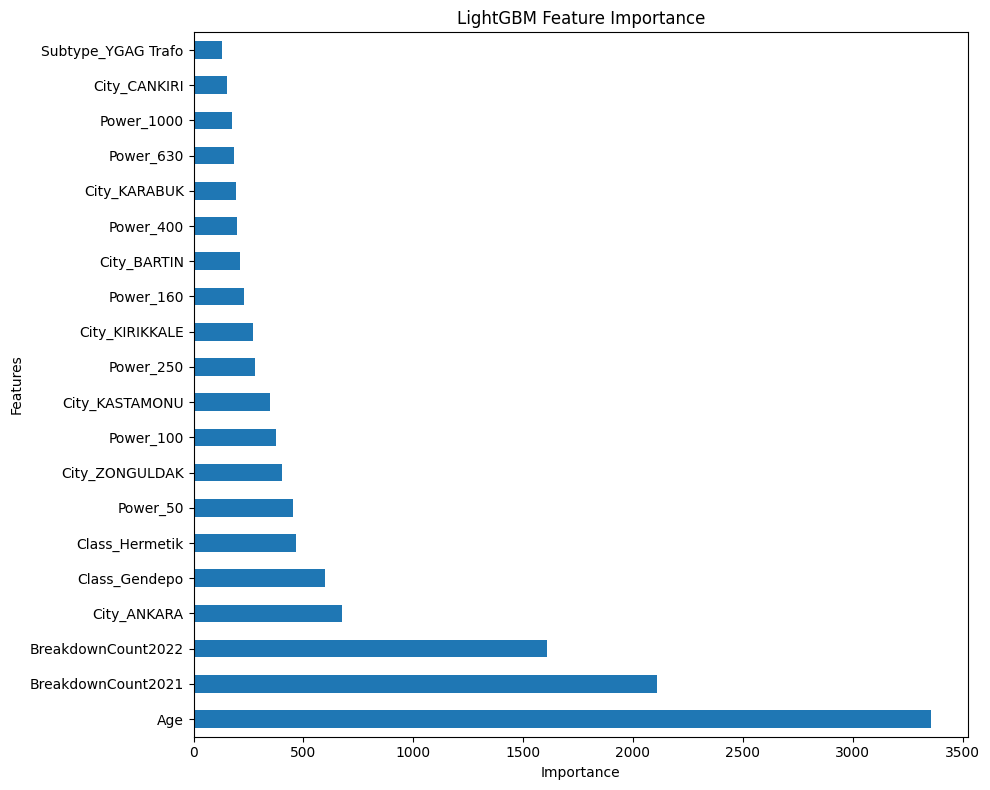

LightGBM Feature Importances:


,0
Age,3358
BreakdownCount2021,2109
BreakdownCount2022,1611
City_ANKARA,677
Class_Gendepo,599
Class_Hermetik,468
Power_50,454
City_ZONGULDAK,401
Power_100,374
City_KASTAMONU,350


In [ ]:
# prompt: show the importance of features for  best_lgbm_model

# Get feature importance from the best LightGBM model
feature_importance = best_lgbm_model.feature_importances_

# Create a pandas Series for easier handling and sorting
feature_importance_series = pd.Series(feature_importance, index=X.columns)

# Sort the features by importance
sorted_feature_importance = feature_importance_series.sort_values(ascending=False)[0:20]

# Plot the feature importance
plt.figure(figsize=(10, 8))
sorted_feature_importance.plot(kind='barh')
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Print the feature importance values
print("LightGBM Feature Importances:")
sorted_feature_importance

In [ ]:

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(train_X.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # No activation for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
model.fit(train_X, train_Y, epochs=100, batch_size=32, validation_split=0.2)

# Predict
predictions = model.predict(test_X)  # Or model.predict(train_X) if you're checking fit


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1272/1272 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 10.6466 - mae: 1.4581 - val_loss: 7.7861 - val_mae: 1.5271
Epoch 2/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 9.4136 - mae: 1.4004 - val_loss: 7.7422 - val_mae: 1.3342
Epoch 3/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 9.8689 - mae: 1.4088 - val_loss: 8.5051 - val_mae: 1.2802
Epoch 4/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8.2868 - mae: 1.3928 - val_loss: 8.4195 - val_mae: 1.4055
Epoch 5/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 9.4811 - mae: 1.4130 - val_loss: 10.8258 - val_mae: 1.3100
Epoch 6/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 10.0960 - mae: 1.4350 - val_loss: 8.3238 - val_mae: 1.5115
Epoch 7/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.9134 - mae: 1.4295 - val_loss: 9.9203 - val_mae: 1.4248
Epoch 8/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 9.7091 - mae: 1.3919 - val_loss: 7.6849 - val_mae: 1.3859
Epoch 9/100
1272/1272 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# prompt: calculate mse r2 mae

# Evaluate the model
mse_nn = mean_squared_error(test_Y, predictions)
r2_nn = r2_score(test_Y, predictions)
mae_nn = mean_absolute_error(test_Y, predictions)

print("Mean Squared Error (MSE) for Neural Network:", mse_nn)
print("R-squared (R2) for Neural Network:", r2_nn)
print("Mean Absolute Error (MAE) for Neural Network:", mae_nn)

Mean Squared Error (MSE) for Neural Network: 11.784439086914062
R-squared (R2) for Neural Network: 0.3349016308784485
Mean Absolute Error (MAE) for Neural Network: 1.3903900384902954


In [ ]:
# prompt: calculate train performance metrics

# Make predictions on the training data
train_predictions = model.predict(train_X)

# Calculate metrics for training data
train_mse = mean_squared_error(train_Y, train_predictions)
train_r2 = r2_score(train_Y, train_predictions)
train_mae = mean_absolute_error(train_Y, train_predictions)

print("\nTraining Performance Metrics (Neural Network):")
print("Mean Squared Error (MSE):", train_mse)
print("R-squared (R2):", train_r2)
print("Mean Absolute Error (MAE):", train_mae)

1590/1590 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Training Performance Metrics (Neural Network):
Mean Squared Error (MSE): 7.226796627044678
R-squared (R2): 0.5246368050575256
Mean Absolute Error (MAE): 1.3670780658721924


In [10]:
def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(Dense(
        units=hp.Int('units_input', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation_input', values=['relu', 'tanh']),
        input_shape=(train_X.shape[1],)
    ))

    # Hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):  # Try 1 to 3 hidden layers
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=16, max_value=256, step=32),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        ))

    # Output layer (no activation for regression)
    model.add(Dense(1))

    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model


In [14]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='regression_tuning'
)

tuner.search(train_X, train_Y, epochs=50, validation_split=0.2, batch_size=32)

best_model = tuner.get_best_models(num_models=1)[0]
predictions = best_model.predict(test_X)

best_hps = tuner.get_best_hyperparameters(1)[0]
print(best_hps.values)



Trial 10 Complete [00h 03m 58s]
val_mae: 1.3256996870040894

Best val_mae So Far: 1.2734334468841553
Total elapsed time: 00h 38m 19s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
{'units_input': 192, 'activation_input': 'relu', 'num_layers': 3, 'units_0': 16, 'activation_0': 'tanh', 'optimizer': 'rmsprop', 'units_1': 208, 'activation_1': 'tanh', 'units_2': 208, 'activation_2': 'tanh'}


In [15]:
train_preds = best_model.predict(train_X).flatten()
test_preds = best_model.predict(test_X).flatten()

# Train metrics
train_mae = mean_absolute_error(train_Y, train_preds)
train_mse = mean_squared_error(train_Y, train_preds)
train_r2 = r2_score(train_Y, train_preds)

# Test metrics
test_mae = mean_absolute_error(test_Y, test_preds)
test_mse = mean_squared_error(test_Y, test_preds)
test_r2 = r2_score(test_Y, test_preds)

# Print results
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train R²: {train_r2:.4f}\n")

print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")


1590/1590 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train MAE: 1.2820
Train MSE: 9.2635
Train R²: 0.3907

Test MAE: 1.2420
Test MSE: 10.8994
Test R²: 0.3849


In [11]:
###DATA IS NOT FULLY EXPLANATORY FOR PREDICTING BREAKDOWNS, IT STILL PERFORMS BETTER THAN RANDOM MAINTENANCE STRATEGIES. AMONG THE MODELS TESTED, LIGHTGBM WITH OPTIMIZED PARAMETERS PERFORMED THE BEST AND WAS THEREFORE SELECTED FOR FURTHER USE.
###PREDICTION FOR 2024 WITH LGBM MODEL AND CLUSTERING

X_2024= data.drop(['BreakdownCount2021','BreakdownCount','Inventory','Fider','AverageEffectedPeople','TotalEffectedPeople', 'Weighted2023','Weighted2022', 'Weighted2021','WeightedAll'] ,axis=1)
X_2024 = pd.get_dummies(X_2024, columns=['Subtype','Class', 'Power', 'Type', 'City']).astype(float)
X_2024 = X_2024.dropna()

#Changed the name of the columns to fit model
X_2024.rename(columns={'BreakdownCount2022': 'BreakdownCount2021'}, inplace=True)
X_2024.rename(columns={'BreakdownCount2023': 'BreakdownCount2022'}, inplace=True)


In [13]:
predictions_2024 = best_lgbm_model.predict(X_2024)

In [21]:
pred_df = pd.DataFrame(predictions_2024, columns=['PredictedBreakdowns'])

base_df = data.loc[X_2024.index, ['Fider', 'TotalEffectedPeople']]

pred_df = pred_df.reset_index(drop=True)
base_df = base_df.reset_index(drop=True)

result = pd.concat([base_df, pred_df], axis=1)

In [22]:
result

,Fider,TotalEffectedPeople,PredictedBreakdowns
0,BAA000-18,4607,2.216894
1,BAA000-19,1168,2.716971
2,BAA000-24,2,2.716971
3,BAA000-3,4080,2.849265
4,BAA000-4,1,2.216894
...,...,...,...
63596,TSF154-F,320,0.706512
63597,TSF179-2,11677,0.706512
63598,TSF238-3,1,0.706512
63599,TSF249-3,50,0.472106


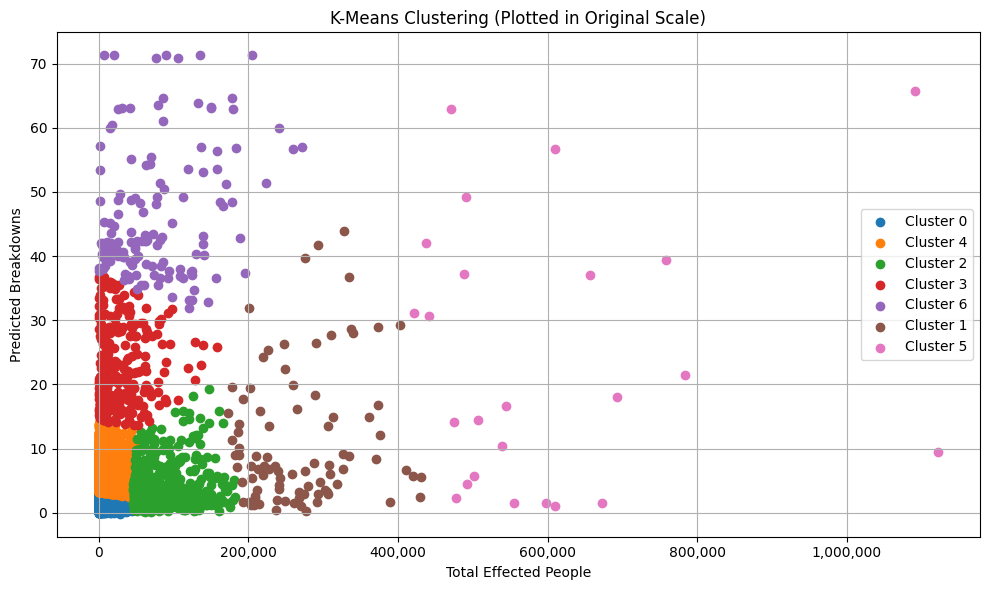

In [33]:

features = result[['TotalEffectedPeople', 'PredictedBreakdowns']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=7, random_state=42)
result['Cluster'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
for cluster in result['Cluster'].unique():
    cluster_data = result[result['Cluster'] == cluster]
    plt.scatter(cluster_data['TotalEffectedPeople'], cluster_data['PredictedBreakdowns'], label=f'Cluster {cluster}')

centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

plt.xlabel('Total Effected People')
plt.ylabel('Predicted Breakdowns')
plt.title('K-Means Clustering (Plotted in Original Scale)')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y):,}'))

plt.tight_layout()
plt.show()


In [ ]:
### MAINTENANCE STRATEGIES CAN BE PRIORITIZED BASED ON THE COMPANY’S OBJECTIVES.
## IF THE GOAL IS TO MINIMIZE THE NUMBER OF PEOPLE AFFECTED BY BREAKDOWNS, THEN CLUSTER 5 AND CLUSTER 1 SHOULD BE PRIORITIZED.
## ON THE OTHER HAND, IF THE FOCUS IS ON REDUCING THE FREQUENCY OF POWER CUTS, CLUSTER 6 AND CLUSTER 3 WOULD BE MORE APPROPRIATE FOR PRIORITIZATION.